In [12]:
# !cp /mnt/bulky2/mgasanov/DSSAT/SoilGridsDssat.ipynb .

In [1]:
# !pip -q install zarr
# !pip -q install xarray[complete]
# !pip -q install rioxarray
# !pip -q install geopandas
# !pip -q install DSSATTools
!pip3 -q install aiohttp
!pip3 -q install gdown
!pip3 -q install salib

In [195]:
from DSSATTools import (
    Crop,
    SoilProfile,
    Weather,
    Management,
    available_cultivars,
)

from DSSATTools import DSSAT
import pandas as pd
from datetime import datetime
import numpy as np
import os
import datetime as dt
import requests
import math
import xarray as xr
from rosetta import rosetta, SoilData

class DSSATModel:
    def __init__(self, ds_weather: xr.Dataset, ds_solar: xr.Dataset) -> None:
        self.ds_weather = ds_weather
        self.ds_solar = ds_solar

        self.MJ_to_J = lambda x: x * 1e6
        self.mm_to_cm = lambda x: x / 10.0
        self.K_to_C = lambda x: x - 273.15
        # self.tdew_to_hpa = lambda x: ea_from_tdew(x) * 10.0
        self.to_date = lambda d: d.date()
        self.HTTP_OK = 200
        self.kg_m2_to_mm = lambda x: x * 86400
        self.ms_to_kmd = lambda x: x * 86.4
        self.watt_to_joules = lambda x: x * 86400
        # To-do: add ALLSKY_SFC_PAR_TOT to weather

    def _csvdate_to_date(self, x, dateformat):
        """Converts string x to a datetime.date using given format.

        :param x: the string representing a date
        :param dateformat: a strptime() accepted date format
        :return: a date
        """
        dt_f = dt.datetime.strptime(str(x), dateformat)
        return dt_f

    def get_elevation(self, longitude: float, latitude: float) -> float:
        """_get_elevation
        Get elevation from OpenTopoData API by lon and lat

        Args:
            longitude (float): longitude in WGS84
            latitude (float): latitude in WGS84

        Returns:
            float: elevation (m)
        """
        url = (
            f"https://api.opentopodata.org/v1/aster30m?locations={latitude},{longitude}"
        )
        resp = requests.get(url=url, timeout=10)
        if resp.status_code == 200:
            data = resp.json()
            elevation = data["results"][0]["elevation"]
        else:
            elevation = 200
        return elevation

    def select_from_xarray(self, longitude: float, latitude: float) -> pd.DataFrame:
        """Select weather from Xarray dataset

        Args:
            longitude (float): point longitude
            latitude (float): point latitude

        Returns:
            pd.DataFrame: weather dataframe
        """
        point_weather = self.ds_weather.sel(
            lon=longitude, lat=latitude, method="nearest"
        )
        point_solar = self.ds_solar.sel(lon=longitude, lat=latitude, method="nearest")
        df_power = self.xr_dataset_to_pandas(ds=point_weather)

        df_solar = self.xr_dataset_to_pandas(ds=point_solar)

        df_power["DAY"] = pd.to_datetime(point_weather.time.values, format="%Y%m%d")

        df_solar = (
            df_solar.apply(self.watt_to_joules) / 1e6
        )  # Convert to MJ for A,B computing

        df_power = pd.concat([df_power, df_solar], axis=1)
        return df_power

    def xr_dataset_to_pandas(self, ds: xr.Dataset) -> pd.DataFrame:
        """Convert xarray point to pandas -> faster than implimented"""
        dict_to_pandas = {}
        for key in list(ds.keys()):
            dict_to_pandas[key] = ds[key].values
        return pd.DataFrame(dict_to_pandas)

    def get_dssat_weather(self, longitude: float, latitude: float):

        df_power = self.select_from_xarray(longitude=longitude, latitude=latitude)

        # Convert POWER data to a dataframe with PCSE compatible inputs
        df_dssat = pd.DataFrame(
            {
                "DATE": df_power.DAY.apply(self.to_date),
                "TMEAN": df_power.T2M.apply(self.K_to_C),
                "TMIN": df_power.T2M_MIN.apply(self.K_to_C),
                "TMAX": df_power.T2M_MAX.apply(self.K_to_C),
                "WIND": df_power.WS2M.apply(self.ms_to_kmd),
                "RAD": df_power.ALLSKY_SFC_SW_DWN,
                "RAIN": df_power.PRECTOTCORR.apply(self.kg_m2_to_mm),
                "DEWP": df_power.T2MDEW.apply(self.K_to_C),
                "RHUM": df_power.RH2M,
            }
        )
        df_dssat.loc[:, "DATE"] = df_dssat.loc[:, "DATE"].apply(
            lambda x: self._csvdate_to_date(x, "%Y-%m-%d")
        )
        self.df_dssat = df_dssat.reset_index(drop=True)
        return df_dssat

    def compute(
        self,
        crop_name: str,
        cultivar: str,
        lat: float,
        lon: float,
        harvest: datetime,
        sowing: datetime,
        soil,
        crop = None,
    ):

        df_weather = self.get_dssat_weather(latitude=lat, longitude=lon)
        df_weather["DATE"] = pd.to_datetime(df_weather["DATE"])
        weather_cols = ["DATE", "TMIN", "TMAX", "RAD", "RAIN", "RHUM"]
        wth = Weather(
            df_weather[weather_cols].copy(),
            pars={
                "DATE": "DATE",
                "TMIN": "TMIN",
                "TMAX": "TMAX",
                "RAIN": "RAIN",
                "RAD": "SRAD",
                "RHUM": "RHUM",
            },
            lat=lat,
            lon=lon,
            elev=self.get_elevation(latitude=lat, longitude=lon),
        )
        # soil = SoilProfile(default_class="SCL")
        if crop is None:
            crop = Crop(crop_name, cultivar)
        man = Management(planting_date=sowing, irrigation="A")

        man.harvest_details["HDATE"] = harvest.strftime("%y%j")
        man.harvest_details["HPC"] = 100

        #
        dssat = DSSAT()
        dssat.setup()

        dssat.run(
            soil=soil,
            weather=wth,
            crop=crop,
            management=man,
        )
        if "PlantGro" in dssat.output:  # type: ignore
            output_1 = dssat.output["PlantGro"]  # type: ignore
            dssat.close()
            return float(output_1["CWAD"].max())
        else:
            raise ValueError("DSSAT no output")


## 1. Погода

In [2]:
'''
*Version: 1.0 Published: 2022/05/31* Source: [NASA POWER](https://power.larc.nasa.gov/)
POWER Remotely Connect to a POWER Zarr via Python
This is an overview of the process to remotely connect to a POWER Zarr formatted Analysis Ready Dataset (ARD) via Python.
'''

import fsspec
import xarray as xr
import rioxarray
import geopandas as gpd
import requests

product = 'power_901_daily_meteorology_utc.zarr'

solar_product = "power_901_daily_radiation_utc.zarr"

filepath = f'https://power-analysis-ready-datastore.s3.amazonaws.com/{product}'

filepath_mapped = fsspec.get_mapper(filepath)
ds = xr.open_zarr(store=filepath_mapped, consolidated=True)

filepath = f'https://power-analysis-ready-datastore.s3.amazonaws.com/{solar_product}'
filepath_mapped = fsspec.get_mapper(filepath)
ds_solar = xr.open_zarr(store=filepath_mapped, consolidated=True)
ds_solar


/usr/local/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset>
Dimensions:              (time: 14976, lat: 180, lon: 360)
Coordinates:
  * lat                  (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                  (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * time                 (time) datetime64[ns] 1984-01-01 ... 2024-12-31
Data variables: (12/44)
    AIRMASS              (time, lat, lon) float64 dask.array<chunksize=(14976, 30, 30), meta=np.ndarray>
    ALLSKY_KT            (time, lat, lon) float64 dask.array<chunksize=(14976, 30, 30), meta=np.ndarray>
    ALLSKY_NKT           (time, lat, lon) float64 dask.array<chunksize=(14976, 30, 30), meta=np.ndarray>
    ALLSKY_SFC_LW_DWN    (time, lat, lon) float64 dask.array<chunksize=(14976, 30, 30), meta=np.ndarray>
    ALLSKY_SFC_LW_UP     (time, lat, lon) float64 dask.array<chunksize=(14976, 30, 30), meta=np.ndarray>
    ALLSKY_SFC_PAR_TOT   (time, lat, lon) float64 dask.array<chunksize=(14976, 30, 30), meta=np.ndarray>
    ...                   ...
    SG_DAY_HOURS         (time, lat, lon) float64 dask.array<chunksize=(14976, 30, 30), meta=np.ndarray>
    SG_NOON              (time, lat, lon) float64 dask.array<chunksize=(14976, 30, 30), meta=np.ndarray>
    SZA                  (time, lat, lon) float64 dask.array<chunksize=(14976, 30, 30), meta=np.ndarray>
    TOA_SW_DNI           (time, lat, lon) float64 dask.array<chunksize=(14976, 30, 30), meta=np.ndarray>
    TOA_SW_DWN           (time, lat, lon) float64 dask.array<chunksize=(14976, 30, 30), meta=np.ndarray>
    ZENITH_LUMINANCE     (time, lat, lon) float64 dask.array<chunksize=(14976, 30, 30), meta=np.ndarray>
Attributes: (12/37)
    acknowledgement:            The Prediction of Worldwide Energy Resources ...
    comment:                    Version 9.0.1 includes source data resolution.
    conventions:                CF-1.8, ACDD-1.3
    creator_email:              bradley.macpherson@nasa.gov
    creator_name:               Bradley Macpherson
    date_created:               2021-06-16T10:30:00.000000
    ...                         ...
    time_coverage_end:          2024-12-31T00:00:00
    time_coverage_resolution:   P1D
    time_coverage_start:        1984-01-01T00:00:00
    time_standard:              Universal Time Coordinated (UTC)
    title:                      POWER Daily Radiation Time Series
    version:                    POWER Version 9.0.1

In [3]:
solar_variables = ["TOA_SW_DWN",
             "ALLSKY_SFC_SW_DWN"]

weather_variables = ["T2M",
             "T2M_MIN",
             "T2M_MAX",
             "T2MDEW",
             "WS2M",
             "PRECTOTCORR",
             "RH2M"]

ds_solar = ds_solar[solar_variables]
ds = ds[weather_variables]

In [4]:
def clip_by_region(ds:xr.core.dataset.Dataset):
    gdf = gpd.read_file('https://raw.githubusercontent.com/leakyMirror/map-of-europe/master/GeoJSON/europe.geojson')
    gdf = gdf.set_crs('EPSG:4326')
    ds.rio.write_crs("epsg:4326", inplace=True)
    clipped = ds.rio.clip(gdf.geometry.values, gdf.crs)
    return clipped

In [5]:
ds_eu = clip_by_region(ds=ds)
ds_eu_solar = clip_by_region(ds=ds_solar)

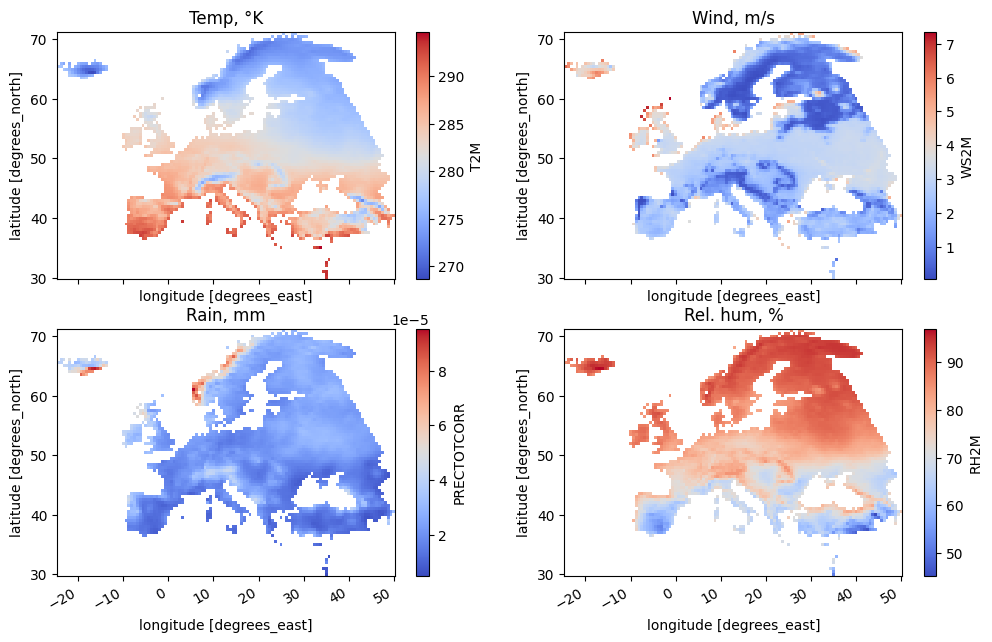

In [6]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,ncols=2, figsize=(12,8))
fig.autofmt_xdate()

target_plots = ["T2M",
             "WS2M",
             "PRECTOTCORR",
             'RH2M']

target_names = ["Temp, °K",
             "Wind, m/s",
             "Rain, mm",
             'Rel. hum, %']
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    select = ds_eu.sel(time=slice('2022-01-01', '2022-12-31'))
    (select.mean(dim='time')[target_plots[i]]).plot(ax=ax, cmap='coolwarm')
    ax.set_title(target_names[i])
# plt.savefig('./nasa_eu.png', dpi=300)

## 2. Агротехнологии

In [7]:
# !gdown 1TT1zf1jjQ6Jf8c2phy1mPKqhXcZ8mVsG
# !gzip -d Soybeans.crop.calendar.fill.nc.gz

In [8]:
class Agrotechnology:
    """
    TO-DO:
    1. Add: major agrotech info for DSSAT, MONICA and WOFOST
    2. AWS: add reading files from AWS S3 storage or from source Drive files (archive?)
    """

    def __init__(self,crop:str, pathCalendar: str='./') -> None:

        self.pathCalendar = pathCalendar
        self.dictCalendars = {
            "barley": "Barley.crop.calendar.fill.nc",
            "soybean": "Soybeans.crop.calendar.fill.nc",
            "sunflower": "Sunflower.crop.calendar.fill.nc",
            "maize": "Maize.crop.calendar.fill.nc",
            "wheat": "Wheat.crop.calendar.fill.nc",
        }
        self.dataset=xr.open_dataset(os.path.join(pathCalendar,self.dictCalendars[crop] ))

    def getCropCalendar(
        self, lon: float, lat: float, year: str = "2022"
    ) -> dict:

        harvest_flt = float(
            self.dataset.sel(latitude=lat, longitude=lon, method="nearest").harvest.values
        )
        plant_flt = float(
            self.dataset.sel(latitude=lat, longitude=lon, method="nearest").plant.values
        )
        if (math.isnan(harvest_flt)) or (math.isnan(plant_flt)):
            return {"plant_day": "NaN", "harvest_day": "NaN"}
        harvest_day = str(
            dt.datetime.strptime(f"{year} {int(harvest_flt)}", "%Y %j").date()
        )
        plant_day = str(
            dt.datetime.strptime(f"{year} {int(plant_flt)}", "%Y %j").date()
        )

        if harvest_day < plant_day:
            plant_day = plant_day.replace(year, year-1)
        return {"plant_day": dt.datetime.strptime(plant_day, '%Y-%m-%d'),
                "harvest_day": dt.datetime.strptime(harvest_day, '%Y-%m-%d')}


In [9]:
agrocalendar = Agrotechnology(crop='soybean', pathCalendar='./')

In [10]:
agrocalendar.getCropCalendar(lon=54, lat=57, year = 2023)

{'plant_day': datetime.datetime(2023, 4, 15, 0, 0),
 'harvest_day': datetime.datetime(2023, 8, 16, 0, 0)}

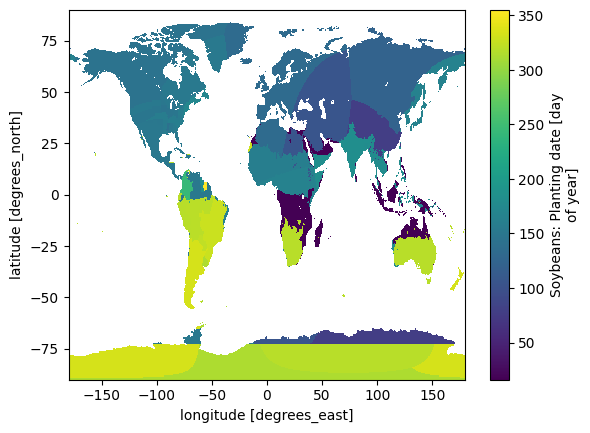

In [11]:
agrocalendar.dataset['plant'].plot()

## 3. Почва

In [14]:
soil = SoilProfile(default_class="SCL")

## 4. Запуск расчета урожайности

In [15]:
year = 2022

ds_eu_year=ds_eu.sel(time=slice(f'{year}-01-01', f'{year}-12-31'))
ds_eu_solar_year=ds_eu_solar.sel(time=slice(f'{year}-01-01', f'{year}-12-31'))

In [16]:
# Load weather data from AWS to local RAM
ds_eu_year.load()
ds_eu_solar_year.load()

<xarray.Dataset>
Dimensions:            (lat: 39, lon: 75, time: 365)
Coordinates:
  * lat                (lat) float64 32.5 33.5 34.5 35.5 ... 67.5 68.5 69.5 70.5
  * lon                (lon) float64 -24.5 -23.5 -22.5 -21.5 ... 47.5 48.5 49.5
  * time               (time) datetime64[ns] 2022-01-01 ... 2022-12-31
    spatial_ref        int64 0
Data variables:
    TOA_SW_DWN         (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    ALLSKY_SFC_SW_DWN  (time, lat, lon) float64 nan nan nan nan ... nan nan nan
Attributes: (12/37)
    acknowledgement:            The Prediction of Worldwide Energy Resources ...
    comment:                    Version 9.0.1 includes source data resolution.
    conventions:                CF-1.8, ACDD-1.3
    creator_email:              bradley.macpherson@nasa.gov
    creator_name:               Bradley Macpherson
    date_created:               2021-06-16T10:30:00.000000
    ...                         ...
    time_coverage_end:          2024-12-31T00:00:00
    time_coverage_resolution:   P1D
    time_coverage_start:        1984-01-01T00:00:00
    time_standard:              Universal Time Coordinated (UTC)
    title:                      POWER Daily Radiation Time Series
    version:                    POWER Version 9.0.1

In [49]:
dssat_runner = DSSATModel(ds_weather = ds_eu_year, 
                          ds_solar = ds_eu_solar_year)

In [18]:
for lat in ds_eu.lat.values:
    for lon in ds_eu.lon.values:
        point_weather = dssat_runner.ds_weather.sel(lon=lon, lat=lat, method="nearest")
        if point_weather['T2M'].sum().values==0:
            continue
        calendar= agrocalendar.getCropCalendar(lon=lon, lat=lat, year = year)
        if calendar['plant_day'] == 'NaN':
            continue
        crop_yield = dssat_runner.compute(crop_name = 'Soybean',
                             cultivar = '999991',
                            lat=lat,
                            lon=lon,
                            harvest = calendar['harvest_day'],
                            sowing= calendar['plant_day'],
                            soil=soil)
        break
    break


/tmp/dssatjeksyocj created.
Static files copied to /tmp/dssatjeksyocj.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  24  80  1333   517     0   227   270    49     0   -99      0  158
/tmp/dssatjeksyocj and its content has been removed.


In [19]:
crop_yield

1781.0

## 5. Анализ чувствительности

In [243]:
from pandas import isna

class SoilSA:
    def __init__(self):
        self.df_eu = pd.read_csv('./soil_coords_eu.csv')
        pass

    # FST_LVL_PARS = [
    #     'SLMH',  'SLLL',  'SDUL',  'SSAT',  'SRGF',  'SSKS',  'SBDM',  'SLOC',
    #     'SLCL',  'SLSI',  'SLCF',  'SLNI',  'SLHW',  'SLHB',  'SCEC',  'SADC'
    # ]
    # SCD_LVL_PARS = [
    #     'SLPX',  'SLPT',  'SLPO', 'CACO3',  'SLAL',  'SLFE',  'SLMN',  'SLBS',
    #     'SLPA',  'SLPB',  'SLKE',  'SLMG',  'SLNA',  'SLSU',  'SLEC',  'SLCA'
    # ]
    
    # LAYER_PARS = FST_LVL_PARS + SCD_LVL_PARS
    
    # DATA_FMT = {
    #     'layer_lvl_1_pars': ['I5', 'A5'] + 4*['F5.3'] + 3*['F5.2'] + 3*['F5.1'] +\
    #     ['F5.3'] + 4*['F5.1'],
    #     'layer_lvl_2_pars': ['I5', 'A5'] + 4*['F5.3'] + 3*['F5.2'] + 3*['F5.1'] +\
    #     ['F5.3'] + 4*['F5.1'],
    #     'profile_lvl_pars': ['A5'] + ['F5.2'] + ['F5.1'] + ['F5.2'] + ['F5.1'] +\
    #         2*['F5.2'] + 3*['A5'],
    #     'location': 2*['A12'] + 2*['F6.3'] + ['A24']
    # }

# soil.layers[30].SCOM = soil.layers[30].get('SCOM')
# soil.layers[30]['@  SLB'] = base_depth
    def van_genuchten(self, theta_r, theta_s, alpha, n, h):
        '''
        Van Genuchten function for soil water retention. Returns theta for a given h (kPa)
        
        Arguments
        ----------
        theta_r: float
            residual water content
        theta_s: float
            saturated water content
        log10(alpha): float
            van Genuchten 'alpha' parameter (1/cm)
        log10(n): float
            van Genuchten 'n' parameter
        '''
        alpha = 10**alpha 
        n = 10**n
        m = 1 - 1/n 
        theta = theta_r + (theta_s - theta_r)/(1 + abs(alpha * h)**n)**m
        return theta

    def aggregate_top_layer(self, soil):
        # top_layer = pd.DataFrame()
        # to_drop = []
        for depth in list(soil.layers.keys()):
            if depth < 30:
                # top_layer = pd.concat([top_layer, soil.layers[depth]], axis=1)
                soil.layers.pop(depth)
        # top_layer=top_layer.mean(axis=1)
        # top_layer.iloc[0] = 30
        # soil.layers[30] = top_layer
        # soil.layers[30] = soil.layers[30].fillna(soil.layers[90]['SLMH'])
        # soil.layers = dict(sorted(soil.layers.items()))
        soil.n_layers = len(soil.layers)
        return soil 

    def estimate_missing(self, soil_layer):
            # Soil Hydraulic parameters are estimated from van_genuchten equation's parameters.
            # Those parameters are estimated using Pedo-Transfer Funcitons (PTF). For this case
            # USDA rosetta model (Zhang et al., 2017) was used. doi: 10.1016/j.jhydrol.2017.01.004
            if isna(soil_layer.SBDM):
                soil_data = SoilData.from_array(
                    [[100 - soil_layer.SLCL - soil_layer.SLSI, soil_layer.SLSI, soil_layer.SLCL]]
                )
                vangenuchten_pars, _, _ = rosetta(2, soil_data)
                # Calculate SBDM
            else:
                soil_data = SoilData.from_array(
                    [[100 - soil_layer.SLCL - soil_layer.SLSI, soil_layer.SLSI, soil_layer.SLCL, soil_layer.SBDM]]
                )
                vangenuchten_pars, _, _ = rosetta(3, soil_data)
    
            vangenuchten_pars = vangenuchten_pars[0]
            soil_layer.SSAT = vangenuchten_pars[1]
            soil_layer.SSKS = (10**vangenuchten_pars[-1]) / 24
            soil_layer.SLLL = self.van_genuchten(*vangenuchten_pars[:-1], h=1500)
            soil_layer.SDUL = self.van_genuchten(*vangenuchten_pars[:-1], h=33)     
        
            if isna(soil_layer.SLOC):
                soil_layer.SLOC = color_to_oc(soil_layer.SCOM)
                soil_layer.SBDM = 1.386 - 0.078*soil_layer.SLOC + 0.001*soil_layer.SLSI + 0.001*soil_layer.SLCL
            else:
                soil_layer.SBDM = 1.72 - 0.294*soil_layer.SLOC**0.5
            
            if isna(soil_layer.SLOC): soil_layer.SLOC = color_to_oc(soil_layer.SCOM)
                
            return soil_layer

    def closest_node(self, node, nodes):
        nodes = np.asarray(nodes)
        deltas = nodes - node
        dist_2 = np.einsum('ij,ij->i', deltas, deltas)
        return np.argmin(dist_2)
    def get_soil_by_coords(self, lon, lat):
        node = [lon, lat] ##weather pointt
        eu_list = self.df_eu.values.tolist()
        nodes = np.hstack((self.df_eu[['X']].values,self.df_eu[['Y']].values))
        node_idx = self.closest_node(node, nodes)
        soil_profile_number = eu_list[node_idx][2]
        soil_profile_country = eu_list[node_idx][3]
        folder = '/mnt/bulky2/mgasanov/DSSAT/dataverse_files/SoilGrids-for-DSSAT-10km v1.0 (by country)/'
        dr = os.path.join(folder, str(soil_profile_country)+'.SOL')
        soilprofile = SoilProfile(
            file=dr,
            profile = soil_profile_number)
        return soilprofile

soil_sa = SoilSA()
soil = soil_sa.get_soil_by_coords(lon=lon, lat=lat)
soil = soil_sa.aggregate_top_layer(soil)
soil.layers[30] = soil_sa.estimate_missing(soil.layers[30])

| Name       | Parameter    | Range     | Unit | 
|------------|--------------|------------------------------------|-------------|
| SRGF       |     Root growth factor, soil only      |        0.0 to 1.0 | -  | 
| SBDM       |  Bulk density    | - | g/cm3  | 
| SLOC       |  Organic carbon  | - | g/cm3  | 
| SLCL       |  Clay    | - | g/cm3  | 
| SLSI       |  Silt    | - | g/cm3  | 
| SLHW       |  Soil pH in water    | - | g/cm3  | 


In [259]:
def get_bounds(soil, soil_cols):
    top_layer = soil.layers[30]
    lower = top_layer[soil_cols].astype(float) * 0.7
    upper = top_layer[soil_cols].astype(float) * 1.3
    upper['SRGF']=1.0
    while upper.SLSI + upper.SLSI > 100:
        upper.SLSI -= 1
        upper.SLSI -= 1
        print(upper.SLSI)
    assert upper.SLSI + upper.SLSI < 100, "Sum of Silt and Clay should be less then 100"
    
    lower = lower.round(4)
    upper = upper.round(4)
    bounds = [[low, up] for low, up in zip(lower, upper)]
    return bounds

def evaluate_soil(X: np.ndarray, soil, soil_cols: list):
    for i, key in enumerate(soil_cols):
        soil.layers[30][key] = X[i]
    soil.layers[30] = soil_sa.estimate_missing(soil.layers[30])
    print(X)
    crop_yield = dssat_runner.compute(crop_name = 'maize',
                     cultivar = '999991',
                    lat=lat,
                    lon=lon,
                    harvest = calendar['harvest_day'],
                    sowing = calendar['plant_day'],
                    soil = soil)
    print('Yield', crop_yield)
    return crop_yield

In [260]:
soil_cols

['SRGF', 'SLOC', 'SLCL', 'SLSI']

In [321]:
import numpy as np

from SALib.test_functions import Ishigami
from SALib import ProblemSpec
from tqdm import tqdm_notebook

soil_cols = [
# "SRGF",
# "SBDM",
"SLOC",
"SLCL",
"SLSI",
# "SLHW"
]

soil = soil_sa.get_soil_by_coords(lon=lon, lat=lat)
soil = soil_sa.aggregate_top_layer(soil)

bounds = get_bounds(soil=soil, soil_cols=soil_cols)

sp = ProblemSpec({
        "names": soil_cols,
        "groups": None,
        "bounds": bounds,
        "outputs": ["Y"],
    })

sp.sample_sobol(16)


Y = np.zeros([sp.samples.shape[0]])
print(Y.shape)
for i, X in tqdm_notebook(enumerate(sp.samples)):
    # pass
    # print(X)
    Y[i] = evaluate_soil(X, soil=soil,soil_cols=soil_cols)
    # print(Y[i])

# # # # Provide the results to the interface
# # # sp.set_results(Y)

# # total_Si, first_Si, second_Si = sp.to_df()

# sp.plot()
# sp.heatmap()


(128,)


/tmp/ipykernel_4621/1041460104.py:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, X in tqdm_notebook(enumerate(sp.samples)):


0it [00:00, ?it/s]

[ 2.0410386  17.65201833 29.75182755]
/tmp/dssatllzwckvx created.
Static files copied to /tmp/dssatllzwckvx.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 MZ   1  55  95  5084  1585   125   148   267   142     0   -99      0  265
/tmp/dssatllzwckvx and its content has been removed.
Yield 5084.0
[ 2.20114347 17.65201833 29.75182755]
/tmp/dssathldonkxx created.
Static files copied to /tmp/dssathldonkxx.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 MZ   1  55  95  5071  1582   125   154   283   133     0   -99      0  270
/tmp/dssathldonkxx and its content has been removed.
Yield 5071.0
[ 2.0410386  19.66637413 29.75182755]
/tmp/dssatafuthxsi created.
Static files copied to /tmp/dssatafuthxsi.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF 

In [286]:
def rename(df):
    df = df.reset_index()
    df = df.rename(columns={'index':'soil_parameter'})
    return df

In [292]:
total_Si = rename(total_Si)

<Axes: title={'center': 'Y'}>

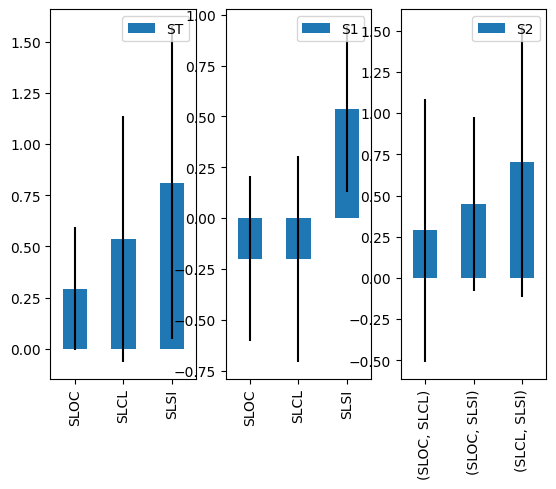

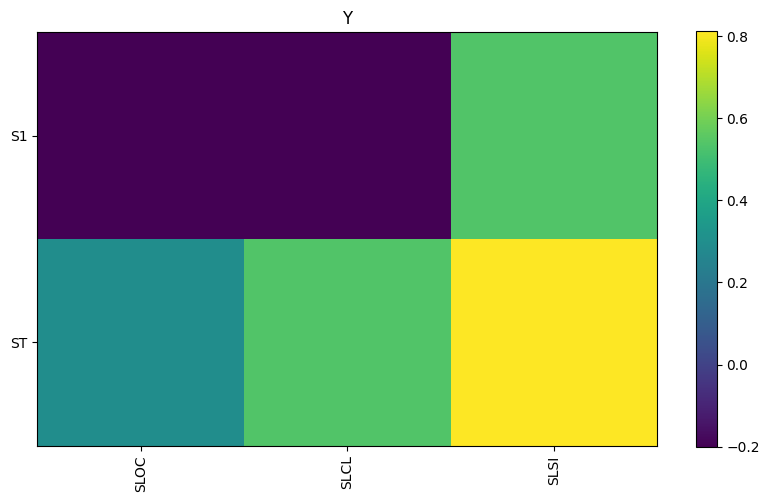

In [322]:
sp.set_results(Y)

sp.analyze_sobol()
total_Si, first_Si, second_Si = sp.to_df()

sp.plot()
sp.heatmap()


In [301]:
sa = {}
for df in [total_Si, first_Si, second_Si]:
    df=rename(df)
    df['lat'] = lat
    df['lon'] = lon

In [305]:
first_Si=rename(first_Si)
first_Si['lat'] = lat
first_Si['lon'] = lon

In [325]:
total_Si, first_Si, second_Si = sp.to_df()
first_Si = first_Si.reset_index().rename(columns={'index':'soil'})
total_Si = total_Si.reset_index(drop=True)
second_Si = second_Si.reset_index().rename(columns={'index':'soil_interaction'})
df_rep = pd.concat([first_Si, total_Si, second_Si], axis=1)
df_rep['lon']=lon
df_rep['lat']=lat

In [331]:
# df_general = pd.DataFrame()
df_general = pd.concat([df_general, df_rep])

In [332]:
df_general

,soil,S1,S1_conf,ST,ST_conf,soil_interaction,S2,S2_conf,lon,lat
0,SLOC,-0.200071,0.406572,0.294249,0.300575,"(SLOC, SLCL)",0.288541,0.799343,41.056801,49.98893
1,SLCL,-0.200405,0.508206,0.536650,0.602755,"(SLOC, SLSI)",0.447164,0.528402,41.056801,49.98893
2,SLSI,0.536990,0.406700,0.811931,0.764558,"(SLCL, SLSI)",0.705535,0.821741,41.056801,49.98893
0,SLOC,-0.200071,0.406572,0.294249,0.300575,"(SLOC, SLCL)",0.288541,0.799343,41.056801,49.98893
1,SLCL,-0.200405,0.508206,0.536650,0.602755,"(SLOC, SLSI)",0.447164,0.528402,41.056801,49.98893
2,SLSI,0.536990,0.406700,0.811931,0.764558,"(SLCL, SLSI)",0.705535,0.821741,41.056801,49.98893


In [327]:
df_rep = pd.concat([first_Si, total_Si, second_Si], axis=1)
df_rep['lon']=lon
df_rep['lat']=lat

In [328]:
df_rep

,soil,S1,S1_conf,ST,ST_conf,soil_interaction,S2,S2_conf,lon,lat
0,SLOC,-0.200071,0.406572,0.294249,0.300575,"(SLOC, SLCL)",0.288541,0.799343,41.056801,49.98893
1,SLCL,-0.200405,0.508206,0.536650,0.602755,"(SLOC, SLSI)",0.447164,0.528402,41.056801,49.98893
2,SLSI,0.536990,0.406700,0.811931,0.764558,"(SLCL, SLSI)",0.705535,0.821741,41.056801,49.98893


In [344]:
sp = ProblemSpec({
        "names": soil_cols,
        "groups": None,
        "bounds": bounds,
        "outputs": ["Y"],
    })

sp.sample_sobol(64)


Y = np.zeros([sp.samples.shape[0]])
print(Y.shape)

(512,)


In [347]:
!rm ../src/sa_task_0_result_*

In [345]:
900 * 512 / 3600 / 24 /10

0.5333333333333333

In [346]:
import time
import math 
import sys 
import multiprocessing
 
def generate_cpu_load(interval=int(10),utilization=int(10)):
    "Generate a utilization % for a duration of interval seconds"
    start_time = time.time()
    for i in range(0,int(interval)):
        print("About to do some arithmetic")
        while time.time()-start_time < utilization/100.0:
            a = math.sqrt(64*64*64*64*64)
        print(str(i) + ". About to sleep")
        time.sleep(1-utilization/100.0)
        start_time += 1
 
#----START OF SCRIPT
# if __name__=='__main__':
print("No of cpu:", multiprocessing.cpu_count())

processes = []
# for _ in range (multiprocessing.cpu_count()):
for _ in range (5):
    p = multiprocessing.Process(target =generate_cpu_load)
    p.start()
    processes.append(p)
for process in processes:
    process.join()        
# else:
#     print("Usage:\n python %s interval utilization"%__file__)

No of cpu: 48
About to do some arithmetic
About to do some arithmetic0. About to sleep
About to do some arithmetic0. About to sleep


0. About to sleepAbout to do some arithmetic

About to do some arithmetic
0. About to sleep
0. About to sleep
About to do some arithmetic
About to do some arithmetic
1. About to sleep
About to do some arithmetic
1. About to sleep
About to do some arithmetic
1. About to sleep
About to do some arithmetic
1. About to sleep
1. About to sleep
About to do some arithmetic
About to do some arithmetic
2. About to sleep
About to do some arithmetic
2. About to sleep
About to do some arithmetic
2. About to sleep
About to do some arithmetic
2. About to sleep
2. About to sleep
About to do some arithmetic
About to do some arithmetic
3. About to sleep
About to do some arithmetic
3. About to sleep
About to do some arithmetic
3. About to sleep
About to do some arithmetic
3. About to sleep
3. About to sleep
About to do some arithmetic
About to do some arithmetic
4. About t